# Portfolio Analysis of financial sector

### Stocks under observation:

    - Visa (NYSE:V) 
    - JPMorgan Chase (NYSE:JPM)
    - Berkshire Hathaway (NYSE:BRK-A)
    - Goldman Sachs Group (NYSE:GS)
    - Square (NYSE:SQ)
    - American Express Co. (NYSE:AXP)


In [12]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as wb
import scipy.optimize as sco
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Pulling stock data 

In [13]:
financial = ['V', 'JPM', 'BRK-A', 'GS','SQ', 'AXP' ]
data = pd.DataFrame()
for i in range(len(financial)):
    
    df = wb.DataReader(financial[i], data_source='yahoo', start='2019-1-1', end = '2020-5-1')
    df['stock'] = financial[i]
    data = data.append(df[['Adj Close', 'stock']])

table = data.pivot(columns='stock')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,AXP,BRK-A,GS,JPM,SQ,V
Date,,,,,,
2019-01-02,93.452377,304057.0,167.530792,94.704803,57.200001,131.661087
2019-01-03,91.628242,287000.0,165.076675,93.358879,52.419998,126.916458
2019-01-04,95.757050,292500.0,170.471802,96.800606,58.180000,132.384171
2019-01-07,96.276825,295400.0,171.416428,96.867889,60.720001,134.771347
2019-01-08,96.747574,294300.0,170.783432,96.685234,63.119999,135.504349


Text(0, 0.5, 'price in $')

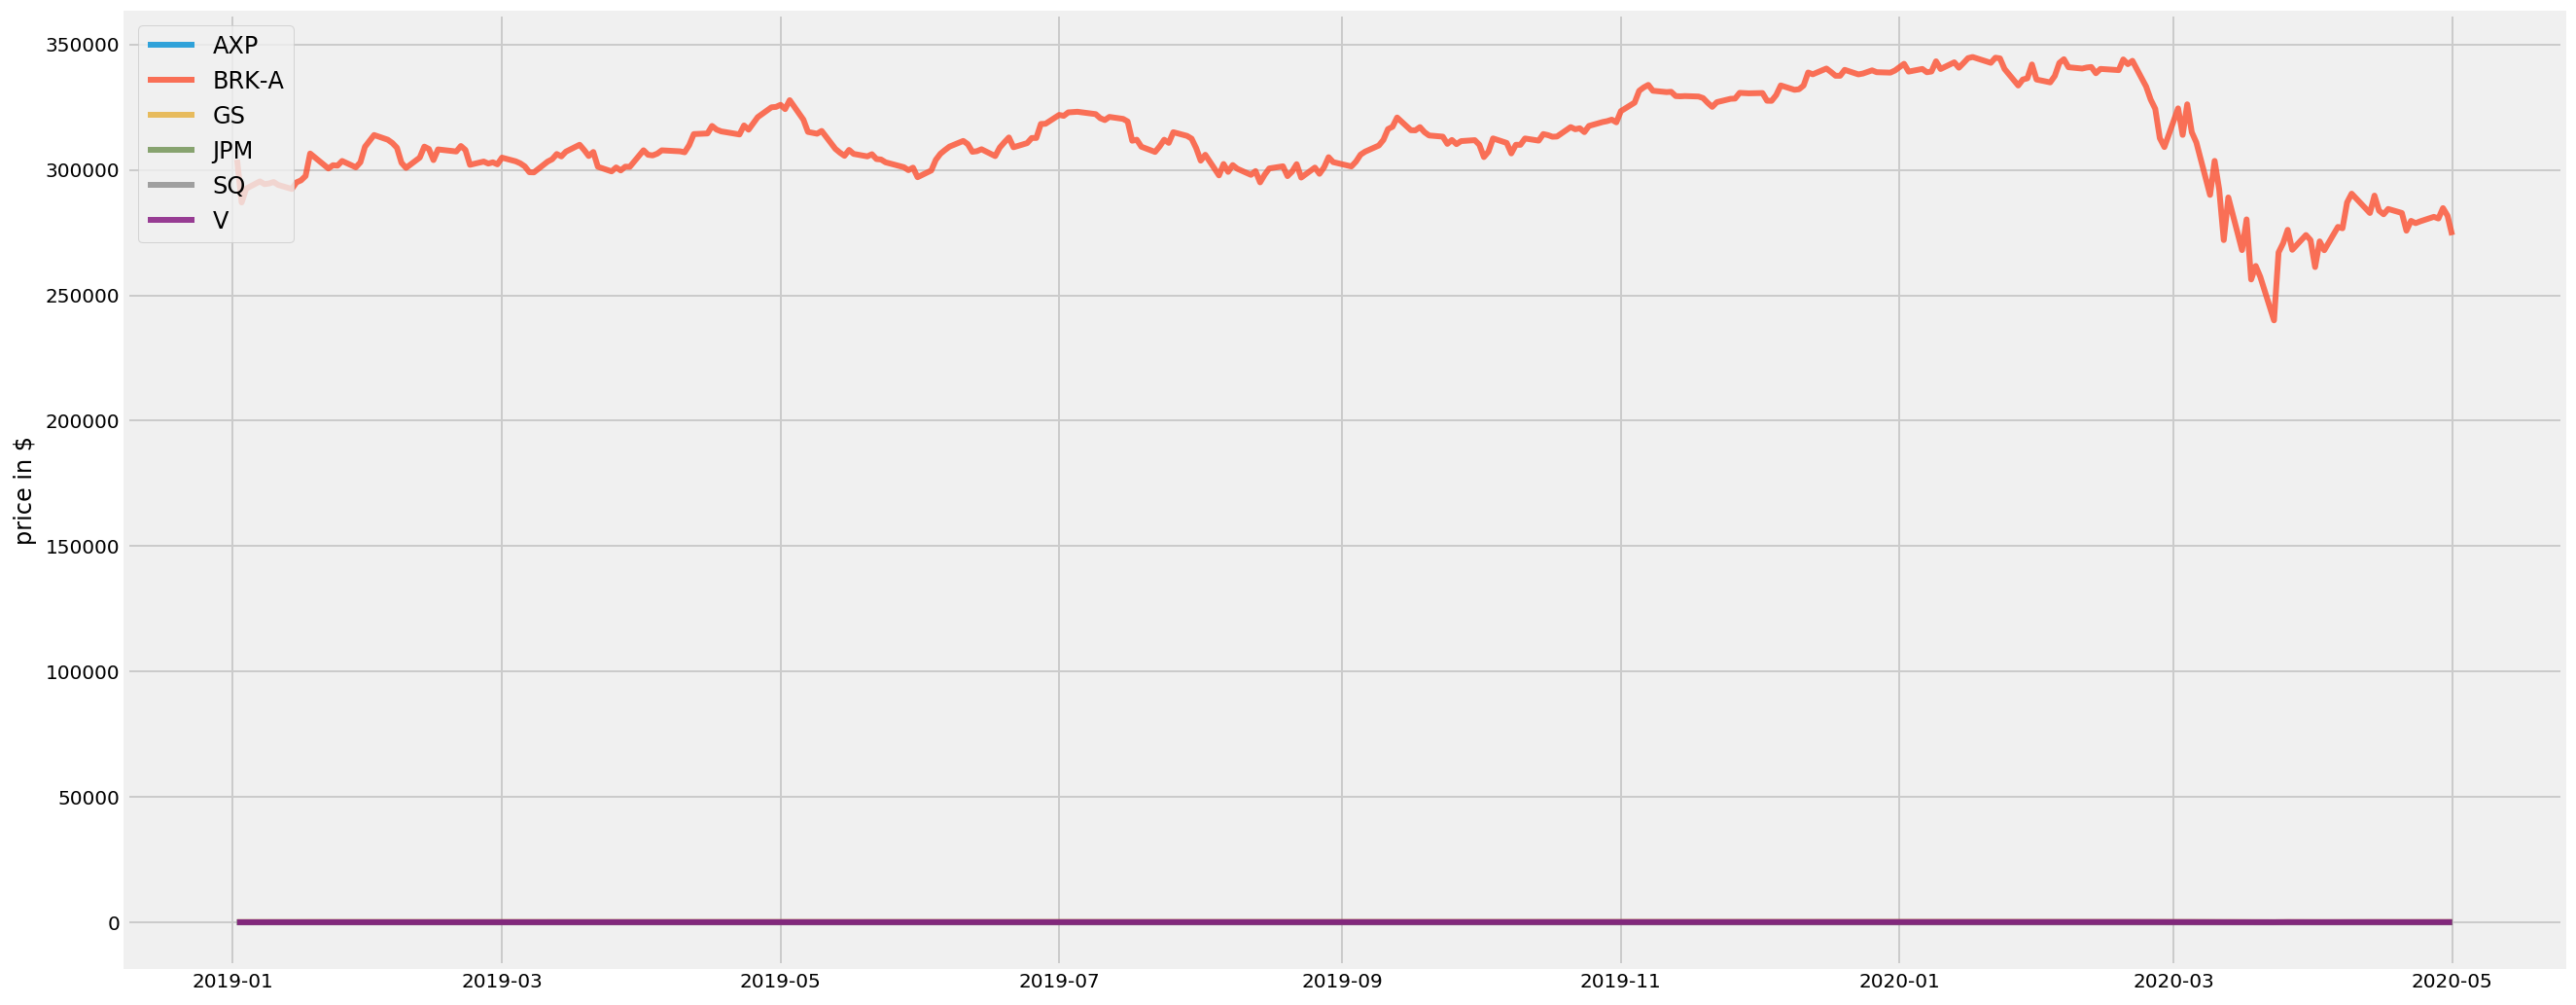

In [14]:
plt.figure(figsize=(20, 9))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

### Simple returns

Text(0, 0.5, 'daily returns')

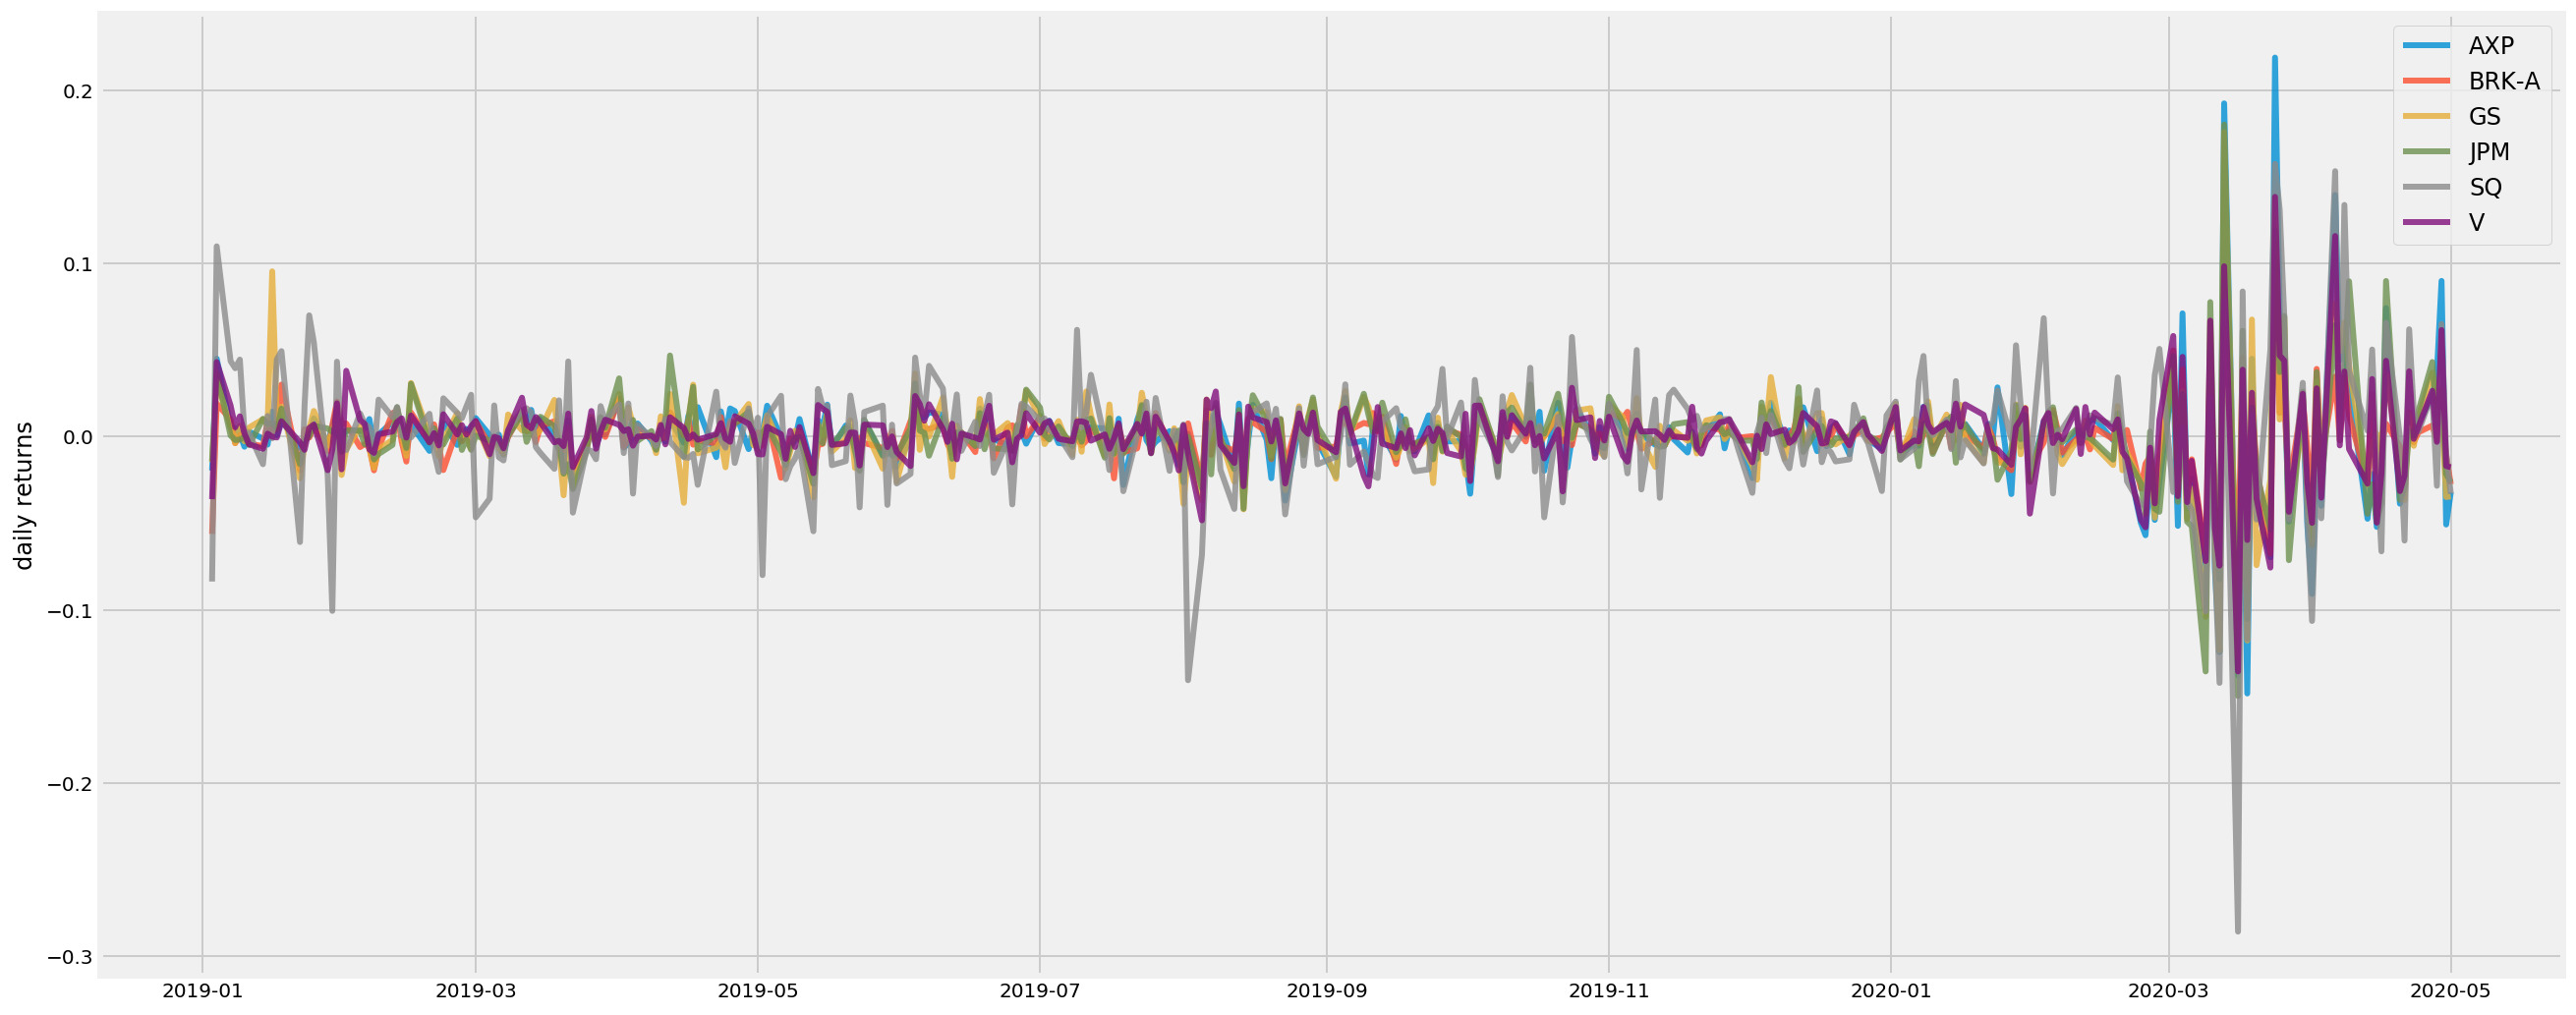

In [15]:
returns = table.pct_change()
plt.figure(figsize=(20, 9))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

### log returns

Text(0, 0.5, 'daily log returns')

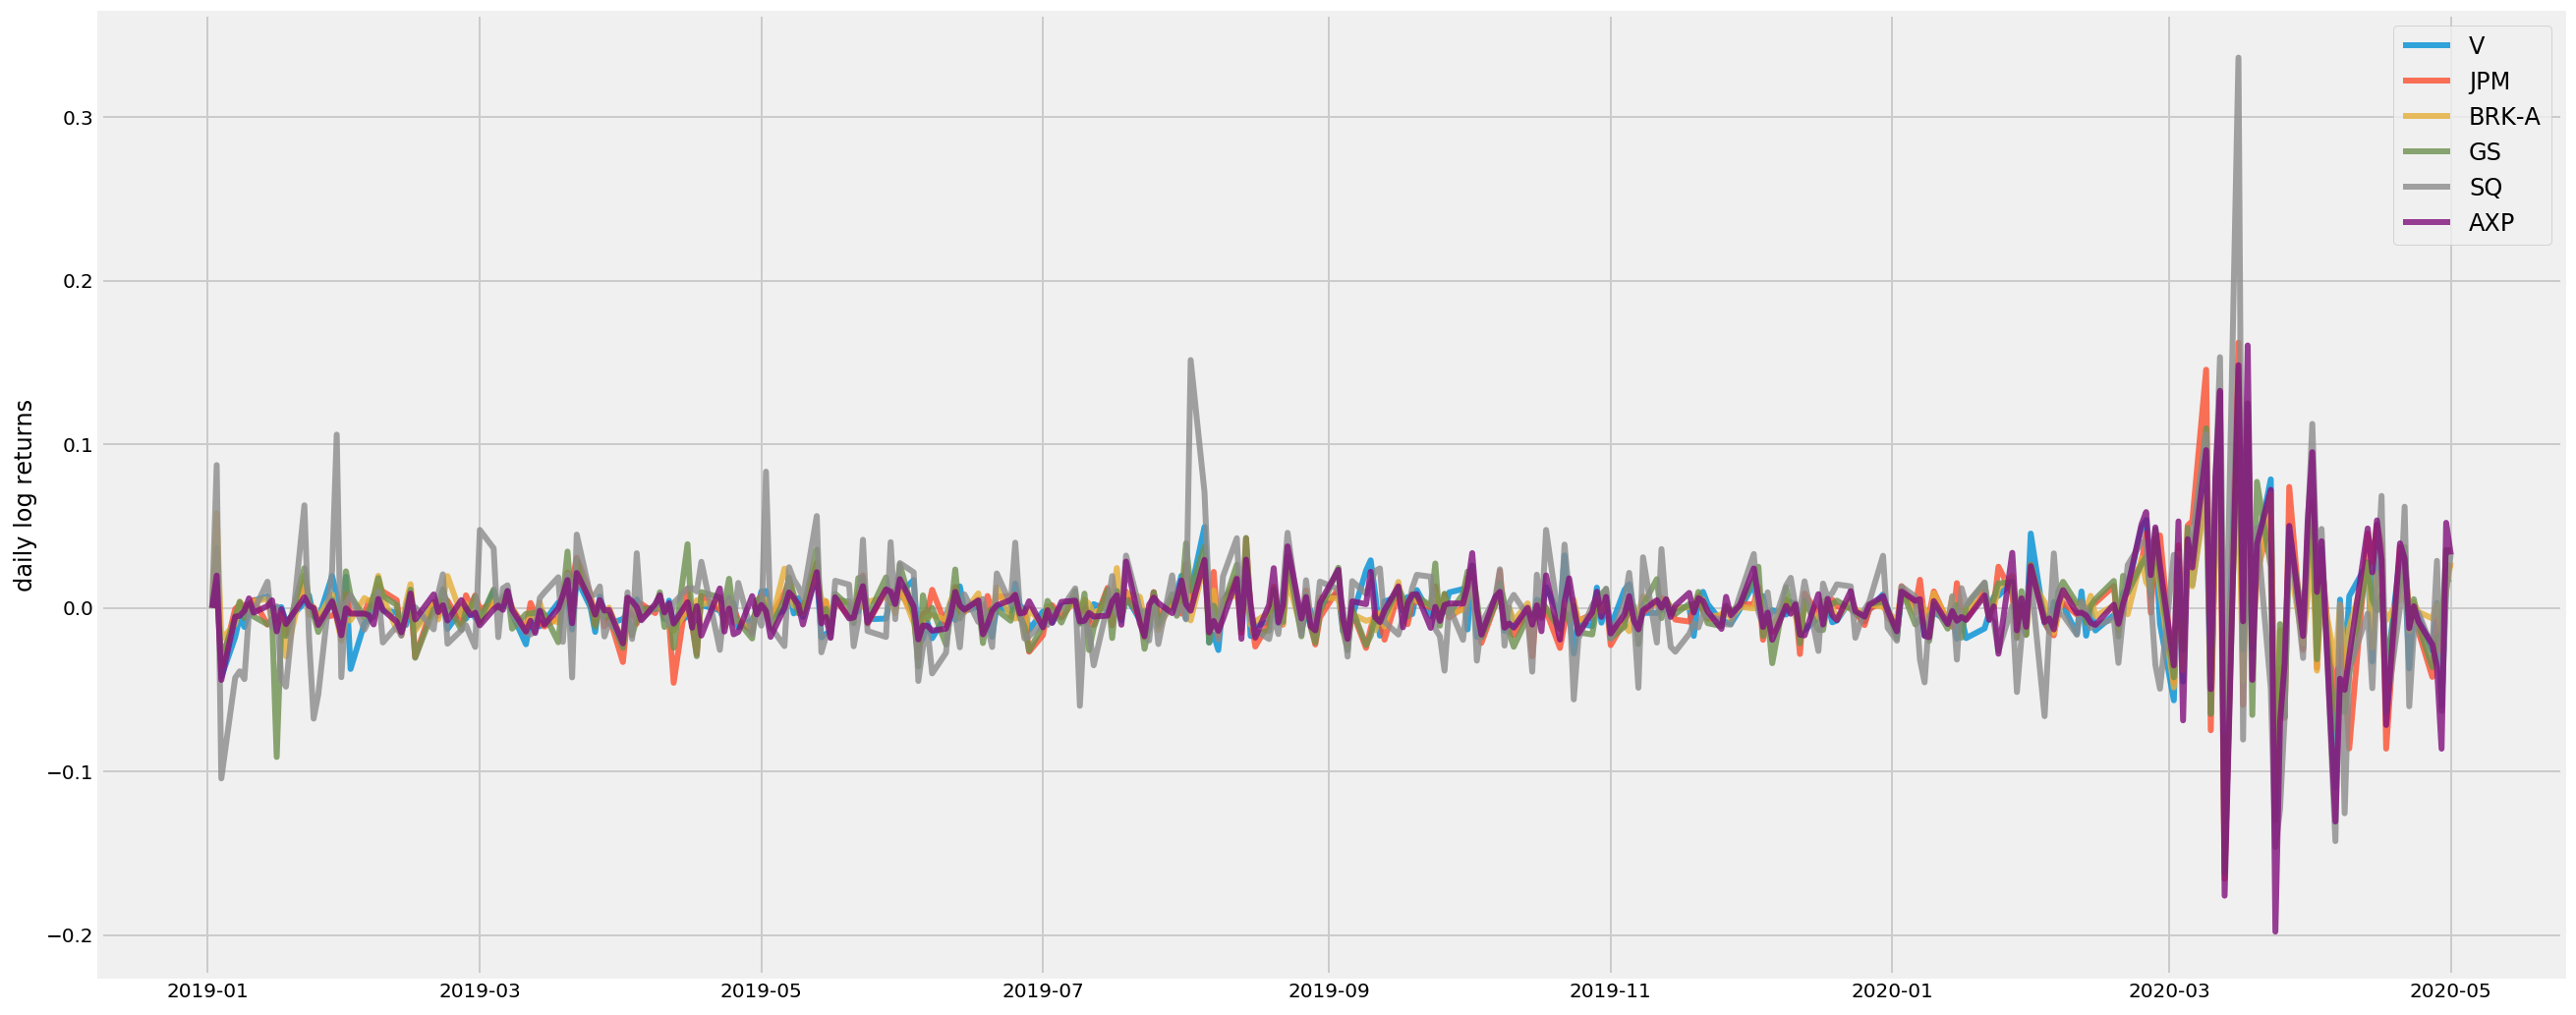

In [16]:
log = pd.DataFrame(columns = financial, index = table.index)

for i in range(len(financial)):
    log_list = []
    for j in range(len(table[financial[i]])):
        if(j+1<len(table[financial[i]])):
            log_returns =  np.log(table[financial[i]][j]) - np.log(table[financial[i]][j+1])
            log_list.append(log_returns)
            

        else:
            None
    log_list.insert(0, 0)   
    log[financial[i]] = log_list


plt.figure(figsize=(20, 9))
for c in log.columns.values:
     plt.plot(log.index, log[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily log returns')


### Normalization to 100

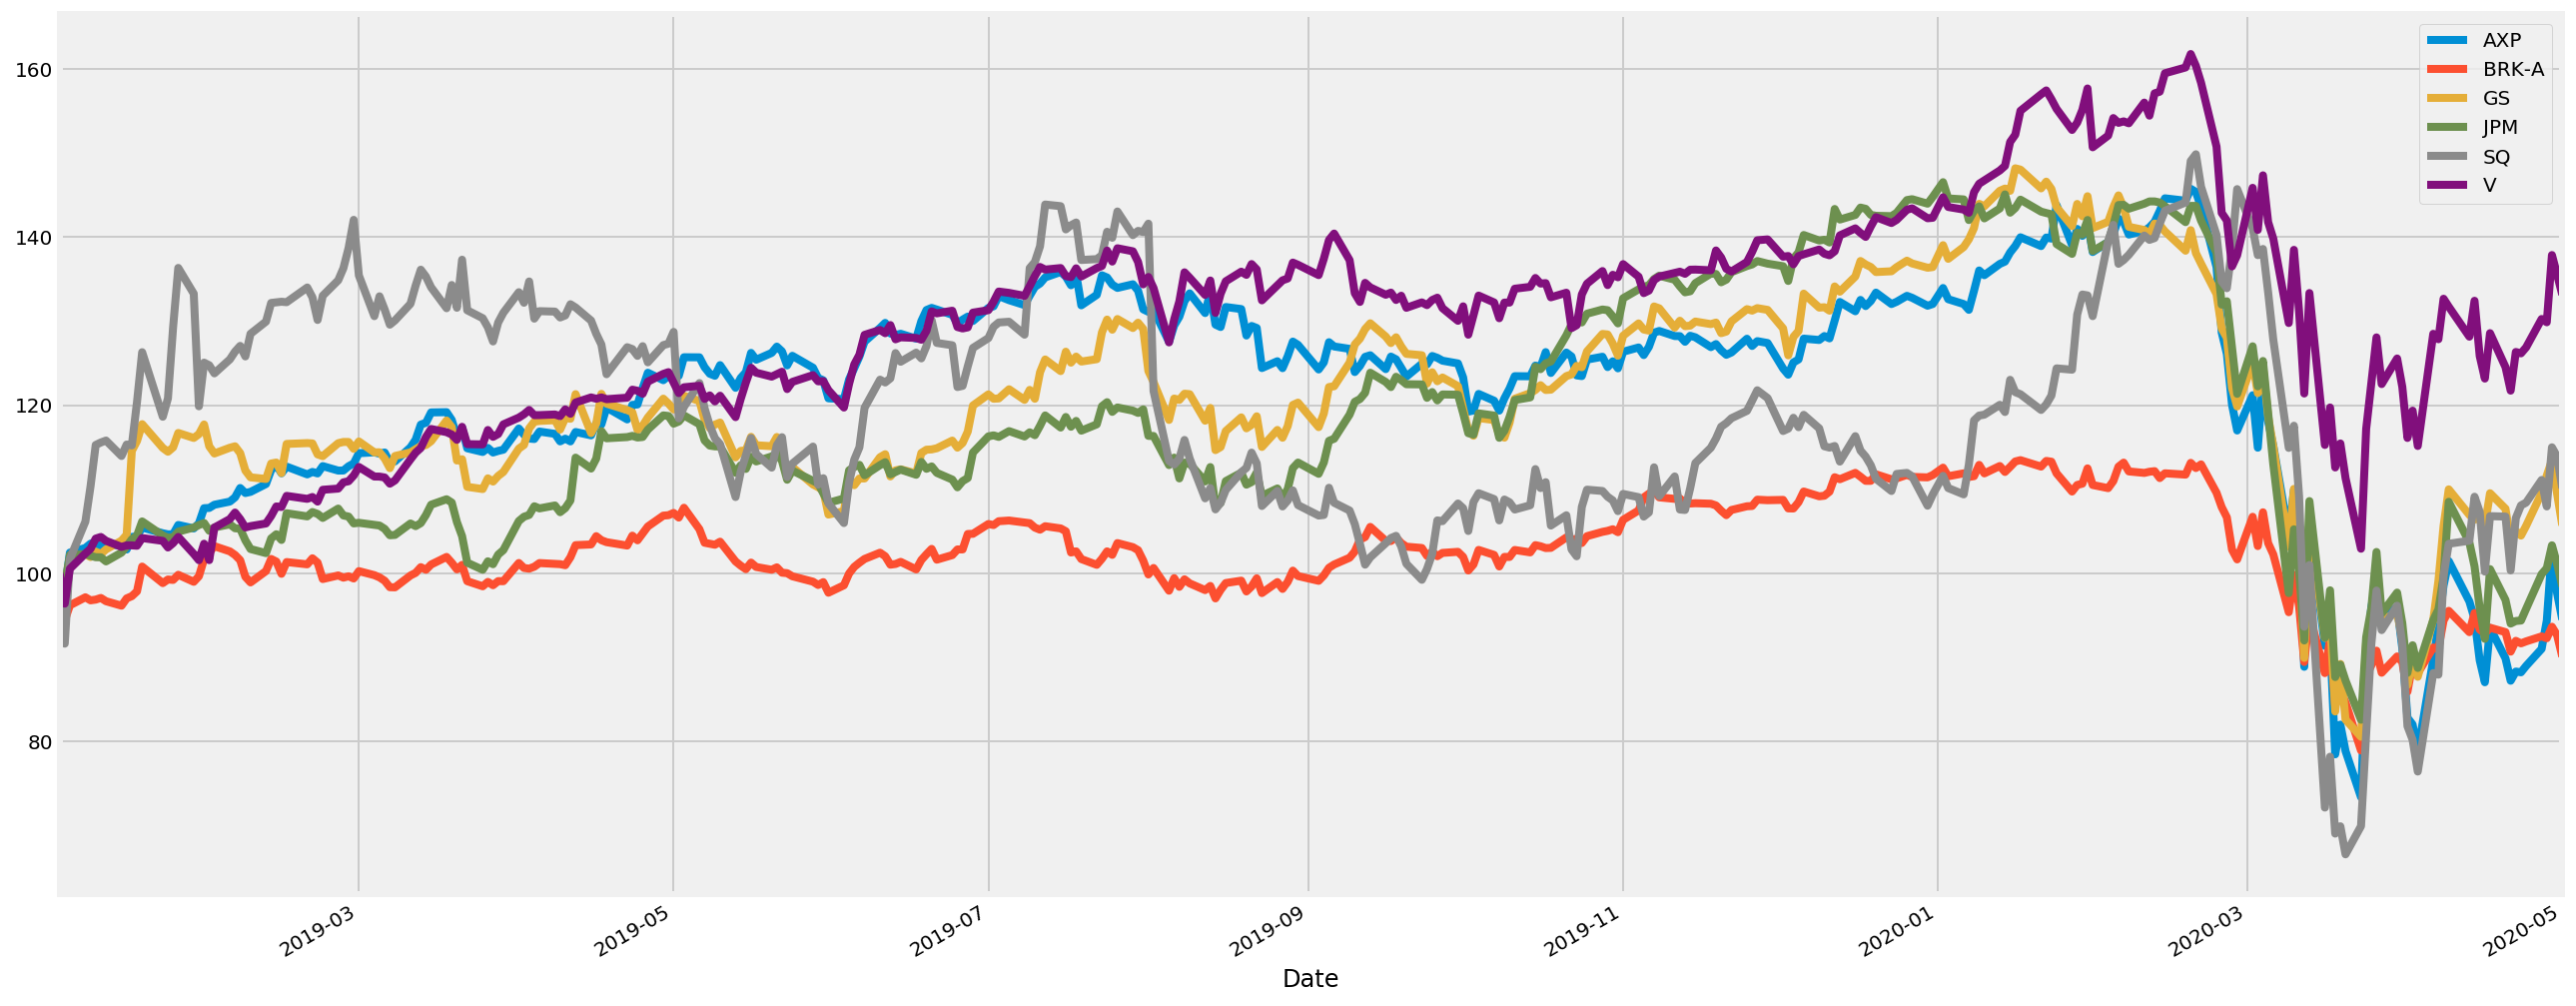

In [17]:
(table/table.iloc[0] * 100).plot(figsize = (20,9))
plt.show()

In [18]:
returns

,AXP,BRK-A,GS,JPM,SQ,V
Date,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.019519,-0.056098,-0.014649,-0.014212,-0.083566,-0.036037
2019-01-04,0.045060,0.019164,0.032683,0.036866,0.109882,0.043081
2019-01-07,0.005428,0.009915,0.005541,0.000695,0.043658,0.018032
2019-01-08,0.004890,-0.003724,-0.003693,-0.001886,0.039526,0.005439
...,...,...,...,...,...,...
2020-04-27,0.022725,0.006455,0.036949,0.043104,0.024835,0.026536
2020-04-28,0.036798,-0.002361,0.018906,0.007081,-0.028324,-0.002969
2020-04-29,0.089919,0.014786,0.016149,0.026970,0.065101,0.061547


In [19]:
log.mean()*252

V       -0.214600
JPM      0.011610
BRK-A    0.078134
GS      -0.041661
SQ      -0.072436
AXP      0.042364
dtype: float64

In [20]:
log.std()*252**0.5

V        0.360122
JPM      0.417215
BRK-A    0.267856
GS       0.418967
SQ       0.624367
AXP      0.466828
dtype: float64

In [21]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(6)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return(results, weights_record)

mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.0073

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.23
Annualised Volatility: 0.36


             AXP  BRK-A    GS    JPM    SQ      V
allocation  1.21   5.19  1.94  10.94  8.95  71.78
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.03
Annualised Volatility: 0.29


             AXP  BRK-A    GS   JPM    SQ      V
allocation  8.68  68.21  0.86  4.37  0.18  17.69


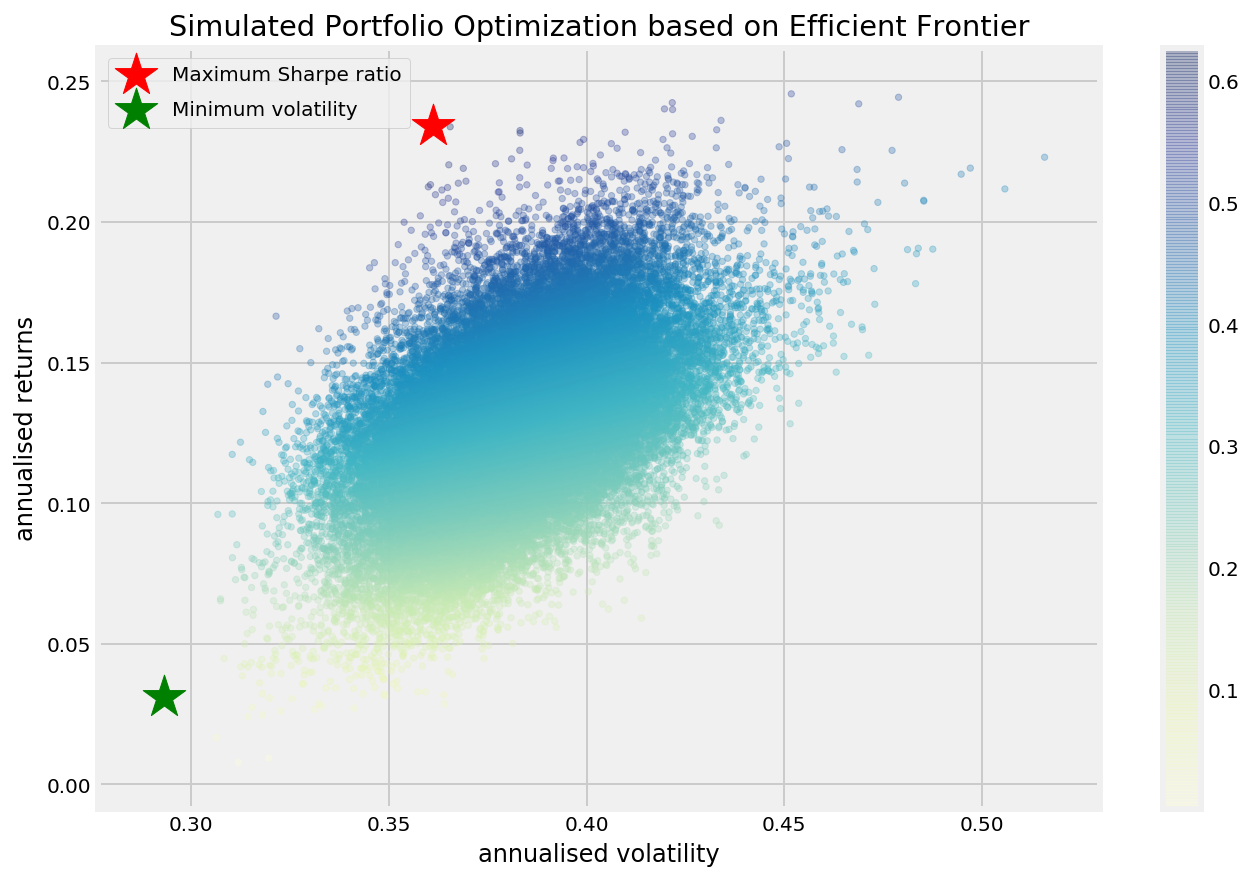

In [22]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)